# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./demo04_breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform binary classification, and evaluating performance using various metrics
* Perform multi-class logistic classification, and evaluating performance using accuracy and confusion matrix
* Use L1-regularization to promote sparse weights for improved estimation (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [10]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls', index_col=0)
df.head(6)


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
309_6,0.447506,0.628176,0.367388,2.385939,4.807635,0.218578,0.176233,2.141282,0.195188,1.442398,...,0.109446,0.439833,0.116657,0.140766,0.142180,1.816389,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [11]:
# TODO
df_1 = df.copy()
df_1.isna()
df_1 = df.fillna(df.mean(axis=0))
df_1.head(6)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
309_6,0.447506,0.628176,0.367388,2.385939,4.807635,0.218578,0.176233,2.141282,0.195188,1.442398,...,0.109446,0.439833,0.116657,0.140766,0.142180,1.816389,Control,Memantine,C/S,c-CS-m


## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1. 

In [12]:
# TODO
a, y = np.unique(df_1['Genotype'].values, return_inverse=True)

In [13]:
df_1['Genotype'] = y

In [14]:
df_1

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,0,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,0,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,0,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,0,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,0,Memantine,C/S,c-CS-m
309_6,0.447506,0.628176,0.367388,2.385939,4.807635,0.218578,0.176233,2.141282,0.195188,1.442398,...,0.109446,0.439833,0.116657,0.140766,0.142180,1.816389,0,Memantine,C/S,c-CS-m
309_7,0.428033,0.573696,0.342709,2.334224,4.473130,0.225173,0.184004,2.012414,0.195789,1.612036,...,0.111483,0.406293,0.137229,0.156682,0.157499,1.528484,0,Memantine,C/S,c-CS-m
309_8,0.416923,0.564036,0.327703,2.260135,4.268735,0.214834,0.179668,2.007985,0.189803,1.424601,...,0.113080,0.382532,0.123376,0.155612,0.159409,1.652658,0,Memantine,C/S,c-CS-m
309_9,0.386311,0.538428,0.317720,2.125725,4.063950,0.207222,0.167778,1.861514,0.180684,1.261891,...,0.105490,0.435687,0.125173,0.152711,0.158235,1.834599,0,Memantine,C/S,c-CS-m


As predictors, get all but the last four columns of the dataframes.  Standardize the data matrix and call the standardized matrix `Xs`.  The predictors are the expression levels of the 77 genes. 

In [15]:
# TODO
X = df_1.iloc[:, :-4].values
print(X)

[[0.50364388 0.74719322 0.4301753  ... 0.13179003 0.1281856  1.67565235]
 [0.51461708 0.68906355 0.41177034 ... 0.13510297 0.1311187  1.74360965]
 [0.50918309 0.7302468  0.41830878 ... 0.13336183 0.12743108 1.92642659]
 ...
 [0.22869955 0.39517937 0.23411809 ... 0.22919311 0.35521305 1.43082502]
 [0.22124241 0.41289438 0.24397413 ... 0.25131651 0.36535319 1.40403123]
 [0.30262572 0.46105919 0.25656431 ... 0.25299481 0.36527803 1.37099946]]


In [16]:
Xs = preprocessing.scale(X)
Xs.shape

(1080, 77)

###### Create a `LogisticRegression` object `logreg` and `fit` the training data. Use `C = 1e5`.

In [17]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs,y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy of the classifer.  Also, plot the ROC curve, and measure the AUC. Later, we will properly measure the accuracy and AUC on cross-validation data.

In [18]:
# TODO
yhat_train = logreg.predict(Xs)
acc = np.mean(yhat_train == y)
print('Accuracy : {0: .4f}'.format(acc))

Accuracy :  1.0000


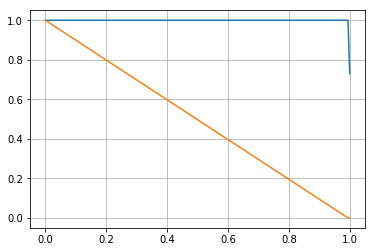

In [19]:
from sklearn import metrics
yprob = logreg.predict_proba(Xs)
fpr, tpr, thresholds = metrics.roc_curve(y, yprob[:,1])
plt.plot(thresholds, tpr,  thresholds, fpr)
plt.grid()

In [20]:
auc=metrics.roc_auc_score(y,yprob[:,1])
print("AUC=%f" % auc)

AUC=1.000000


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.    

<Container object of 3 artists>

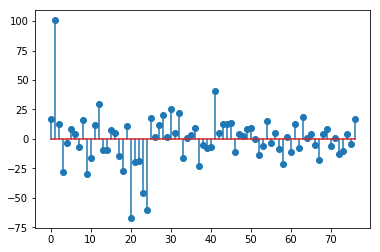

In [21]:
# TODO
w = logreg.coef_
W = w.ravel()
plt.stem(W) 

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.  

Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [23]:
# TODO
ind = np.argsort(np.abs(W))
xnames = df_1.columns[:-4] 
i1 = ind[-1] # largest element
i2 = ind[-2] # second largest element
name1 = xnames[i1]
name2 = xnames[i2]
print('The two most significant genes are {0:s} and {1:s}'.format(name1,name2)) 

The two most significant genes are ITSN1_N and BRAF_N


## Cross Validation

The above meaured the accuracy on the training data.  It is more accurate to measure the accuracy on the test data.  Perform 10-fold cross validation and measure the average precision, recall and f1-score, as well as the AUC.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [24]:
# TODO
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
prec = []
rec = []
f1 = []
err_rate = []
auc = [ ]
for Itr, Its in kf.split(Xs):
 # Get training and test data
 Xtr = Xs[Itr,:]
 ytr = y[Itr]
 Xts = Xs[Its,:]
 yts = y[Its]
 # Fit a model
 logreg.fit(Xtr, ytr)
 # Predict the labels on the test data
 yhat = logreg.predict(Xts)
 # Measure the precision, recall and f1-score.
 preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary')
 prec.append(preci)
 rec.append(reci)
 f1.append(f1i)
 err_rate.append(np.mean(yts != yhat))
 auc.append(metrics.roc_auc_score(yts,yhat))
# Take the mean performance metrics over the different folds.
prec = np.mean(prec)
rec = np.mean(rec)
f1 = np.mean(f1)
err_mean = np.mean(err_rate)
auc_mean= np.mean(auc)
print('Precision = {0:.4f}'.format(prec))
print('Recall = {0:.4f}'.format(rec))
print('f1 = {0:.4f}'.format(f1))
print('error rate = {0:.4f}'.format(err_mean))
print('AUC = {0:.4f}'.format(auc_mean)) 

Precision = 0.9437
Recall = 0.9609
f1 = 0.9516
error rate = 0.0454
AUC = 0.9534


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  

In [25]:
# TODO
y1 = df_1['class'].values
vals, y = np.unique(y1, return_inverse=True) 

Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method. In general, you could either use the 'one over rest (ovr)' option or the 'multinomial' option. In this exercise use the default 'ovr' and `C=1`. As an optional exercise, you could also compare the results obtained with these two options. 

In [26]:
# TODO
logreg = linear_model.LogisticRegression()
logreg.fit(Xs,y) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Measure the accuracy on the training data.

In [27]:
# TODO
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print('Accuracy on the training data is {0:f}'.format(acc)) 

Accuracy on the training data is 0.999074


Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold.  Also print the overall mean and SE of the test accuracy across the folds.

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
logreg = linear_model.LogisticRegression()

ny = np.max(y)
C = np.zeros((ny+1,ny+1))
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
err_rate = np.zeros(nfold)
for ifold, Ind in enumerate(kf.split(Xs)):
 Itr, Its = Ind
 Xtr = Xs[Itr,:]
 ytr = y[Itr]
 Xts = Xs[Its,:]
 yts = y[Its]

 logreg.fit(Xtr, ytr)
 yhat = logreg.predict(Xts)
 C += confusion_matrix(yts,yhat)
 err_rate[ifold] = np.mean(yhat != yts)

Csum = np.sum(C,1)
C = C / Csum[np.newaxis,:]


In [29]:
# Print the confusion matrix
print(np.array_str(C, precision=4, suppress_small=True))
# Print the overall error rate
err_mean = np.mean(err_rate)
err_se = np.std(err_rate)/np.sqrt(nfold-1)
print("Error rate =%12.4e, SE =%12.4e" % (err_mean,err_se)) 

[[0.9667 0.0074 0.0067 0.     0.0222 0.     0.     0.    ]
 [0.0067 0.9852 0.     0.     0.0074 0.     0.     0.    ]
 [0.     0.     0.9933 0.     0.     0.     0.     0.0074]
 [0.0067 0.     0.     0.9852 0.0074 0.     0.     0.    ]
 [0.0067 0.0074 0.     0.     0.9852 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
Error rate =  1.1111e-02, SE =  3.3242e-03


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes for the first class.

<Container object of 3 artists>

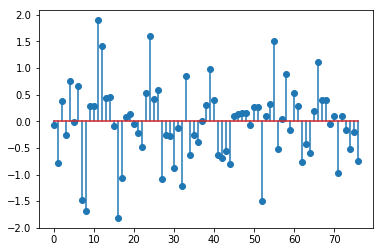

In [30]:
# TODO
logreg = linear_model.LogisticRegression()
logreg.fit(Xs,y)
W = logreg.coef_
plt.stem(W[0,:])

## L1-Regularization

Graduate students only complete this section.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [prostate cancer analysis demo](../unit03_model_sel/demo03_2_prostate.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you to find a good range.
* For each C and each fold, you should compute the classification error rate 
* For each C and each fold, you should also determine the nubmer of non-zero coefficients for the first class. For this purpse, you can assume coefficient with magnitude <0.01 as zero.

In [31]:
# TODO
# Penalty values to test
npen = 20
C_test = np.logspace(-1,3,npen)
# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))
num_nonzerocoef = np.zeros((npen,nfold))
# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)
# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(Xs)):
 # Get training and test data
 Itr, Its = Ind
 Xtr = Xs[Itr,:]
 ytr = y[Itr]
 Xts = Xs[Its,:]
 yts = y[Its]
 # Loop over penalty levels
 for ipen, c in enumerate(C_test):
     logreg.C= c
     logreg.fit(Xtr, ytr)
     yhat = logreg.predict(Xts)
     err_rate[ipen,ifold] = np.mean(yhat != yts)
     num_nonzerocoef[ipen,ifold]=np.sum(abs(logreg.coef_[0,:])>0.001)
 print("Fold %d" % ifold) 

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


Now compute the mean and standard error on the error rate for each `C` and plot the results.  Also determine and print the minimum test error rate and corresponding C value. 

The minimum test error rate =   8.3333e-03, SE=  2.9117e-03
The C value corresponding to minimum error =   2.9764e+00


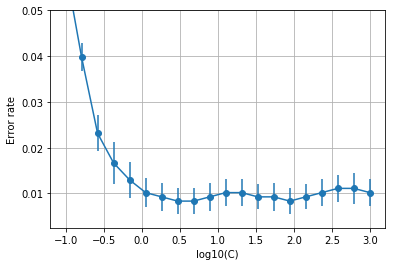

In [32]:
# TODO
err_mean = np.mean(err_rate, axis=1)
num_nonzerocoef_mean = np.mean(num_nonzerocoef, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.ylim([0.0025,0.05])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')
imin = np.argmin(err_mean)
print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % (C_test[imin]))

We see that the minimum error rate is significantly below the classifier that did not use the l1-penalty.  Use the one-standard error rule to determine the optimal `C` and the corresponding test error rate. Note that because `C` is inversely proportional to the regularization strength, you want to select a `C` as *small* as possible while meeting the error target!

In [33]:
# TODO
# C_opt = 
err_tgt = err_mean[imin] + err_se[imin]
iopt = np.where(err_mean < err_tgt)[0][0]
C_opt = C_test[iopt]
print("Optimal C=%12.4e" % C_opt)
print("The test error rate = %12.4e, SE=%12.4e" % (err_mean[iopt], err_se[iopt]))

Optimal C=  1.1288e+00
The test error rate =   1.0185e-02, SE=  3.2223e-03


Now plot the nubmer of non-zero coefficients for the first class for different C values. Also determine and print the number of non-zero coefficients corresponding to C_opt.

The number of non-zero coefficients for the optimal C = 41.000000


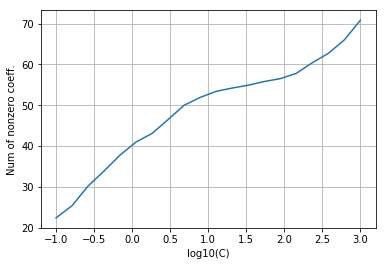

In [34]:
# TODO
num_nonzerocoef_mean = np.mean(num_nonzerocoef, axis=1)
plt.plot(np.log10(C_test),num_nonzerocoef_mean)
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Num of nonzero coeff.')
print("The number of non-zero coefficients for the optimal C = %f" % num_nonzerocoef_mean[iopt])

For the optimal `C`, fit the model on the entire training data with l1 regularization. Find the resulting weight matrix, `W_l1`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  You should see that, with l1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible. Please also compare the accuracy for the training data using optimal `C` with the previous results not using LASSO regularization. Do you expect the accuracy to improve?

Accuracy on the training data is 0.999074


Text(0.5,1,'l1-regularization')

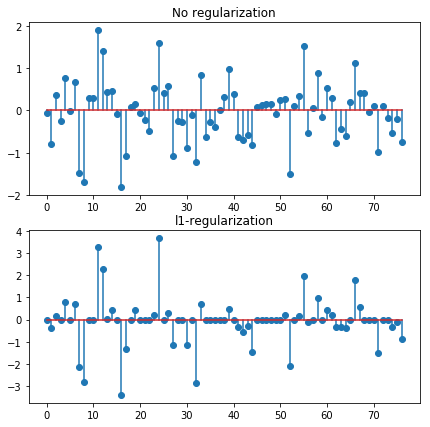

In [35]:
# TODO
logreg = linear_model.LogisticRegression(C=C_opt,penalty='l1')
logreg.C= C_opt
logreg.fit(Xs,y)
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print('Accuracy on the training data is {0:f}'.format(acc))
W_l1 = logreg.coef_
plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.stem(W[0,:])
plt.title('No regularization')
plt.subplot(2,1,2)
plt.stem(W_l1[0,:])
plt.title('l1-regularization') 